# Kernel Methods

In [18]:
import itertools
import numpy as np
import scipy
import socket
import subprocess
import time
import qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import BasicAer as Aer

def get_amplitudes(circuit):
    if isinstance(circuit, qiskit.circuit.quantumcircuit.QuantumCircuit):
        backend = Aer.get_backend('statevector_simulator')
        job = execute(circuit, backend)
        amplitudes = job.result().get_statevector(circuit)
    else:
        raise ValueError("Unknown circuit type")
    return amplitudes

In [19]:
training_set = [[0, 1], [0.70710678118, 0.70710678118]]
labels = [0, 1]
test_set = [[1,0], [0.053 , 0.999]]

def get_angle(amplitude_0):
    return 2*np.arccos(amplitude_0)

q = QuantumRegister(4)
c = ClassicalRegister(4)
backend = Aer.get_backend('qasm_simulator')

test_angle = get_angle(test_set[0])/2
training_angle = get_angle(training_set[1][0])/4

In [20]:
def prepare_state(q, c, angles):
    ancilla_qubit = q[0]
    index_qubit = q[1]
    data_qubit = q[2]
    class_qubit = q[3]
    circuit = QuantumCircuit(q, c)
    # Put the ancilla and the index qubits into uniform superposition
    circuit.h(ancilla_qubit)
    circuit.h(index_qubit)

    # Prepare the test vector
    circuit.cx(ancilla_qubit, data_qubit)
    circuit.u3(-angles[0], 0, 0, data_qubit)
    circuit.cx(ancilla_qubit, data_qubit)
    circuit.u3(angles[0], 0, 0, data_qubit)
    # Flip the ancilla qubit > this moves the input 
    # vector to the |0> state of the ancilla
    circuit.x(ancilla_qubit)
    circuit.barrier()

    # Prepare the first training vector

    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    # Flip the index qubit > moves the first training vector to the |0> state of the index qubit
    circuit.x(index_qubit)
    circuit.barrier()

    # Prepare the second training vector

    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    circuit.cx(index_qubit, data_qubit)
    circuit.u3(angles[1], 0, 0, data_qubit)
    circuit.cx(index_qubit, data_qubit)
    circuit.u3(-angles[1], 0, 0, data_qubit)
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    circuit.cx(index_qubit, data_qubit)
    circuit.u3(-angles[1], 0, 0, data_qubit)
    circuit.cx(index_qubit, data_qubit)
    circuit.u3(angles[1], 0, 0, data_qubit)
    circuit.barrier()

    # Flip the class label for training vector #2
    circuit.cx(index_qubit, class_qubit)
    circuit.barrier()
    return circuit

First Training Instance

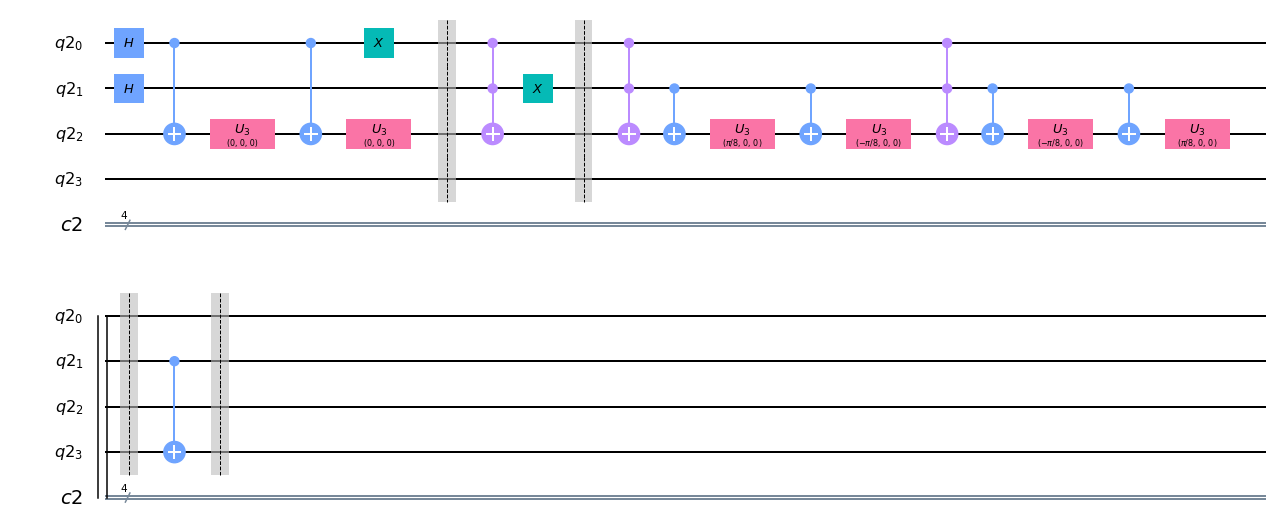

In [21]:
from qiskit.tools.visualization import circuit_drawer
angles = [test_angle[0], training_angle]
state_preparation_0 = prepare_state(q, c, angles)
circuit_drawer(state_preparation_0, output='mpl')

In [22]:
def interfere_data_and_test_instances(circuit, q, c, angles):
    circuit.h(q[0])
    circuit.barrier()
    circuit.measure(q, c)
    return circuit

In [23]:
def postselect(result_counts):
    total_samples = sum(result_counts.values())

    # define lambda function that retrieves only results where the ancilla is in the |0> state
    post_select = lambda counts: [(state, occurences) for state, occurences in counts.items() if state[-1] == '0']

    # perform the postselection
    postselection = dict(post_select(result_counts))
    postselected_samples = sum(postselection.values())

    print(f'Ancilla post-selection probability was found to be {postselected_samples/total_samples}')

    retrieve_class = lambda binary_class: [occurences for state, occurences in postselection.items() if state[0] == str(binary_class)]

    prob_class0 = sum(retrieve_class(0))/postselected_samples
    prob_class1 = sum(retrieve_class(1))/postselected_samples

    print('Probability for class 0 is', prob_class0)
    print('Probability for class 1 is', prob_class1)

In [24]:
angles = [test_angle[0], training_angle]
state_preparation_0 = prepare_state(q, c, angles)
circuit_0 = interfere_data_and_test_instances(state_preparation_0, q, c, angles)
job = execute(circuit_0, backend)
result = job.result()
postselect(result.get_counts(circuit_0))

Ancilla post-selection probability was found to be 0.68359375
Probability for class 0 is 0.37714285714285717
Probability for class 1 is 0.6228571428571429


In [25]:
angles = [test_angle[1], training_angle]
state_preparation_1 = prepare_state(q, c, angles)
circuit_1 = interfere_data_and_test_instances(state_preparation_1, q, c, angles)
job = execute(circuit_1, backend)
result = job.result()
postselect(result.get_counts(circuit_1))

Ancilla post-selection probability was found to be 0.9306640625
Probability for class 0 is 0.5330535152151101
Probability for class 1 is 0.4669464847848898
